## Does the initial patient set influence the evaluation results?

In this analysis, I examine if I can find a specific subset of the initial conditions (patients) which tend to produces evaluation results that contradict the authors' claims.

#### Importing required packages

In [208]:
import gym
import chemo_simulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tqdm

#### Initialize environment, define supporting functions to run experiments

In [3]:
env = gym.make('ChemoSimulation-v0')

In [578]:
def generate_patients(patient_count = 200, seed=0):
    np.random.seed(seed)
    
    # setting initial tumor size to be larger than 0 -> otherwise treatment will not have any effect!
    return np.random.uniform(low=(0,0), high=(2,2), size = (patient_count,2,))

def run_experiment(seed, show_plot = False):
    """
    Function to run the experiment and produce summary results.
    """
    
    dosages =    {'low': np.array([0.1])
                , 'mid': np.array([0.4])
                , 'rand': None
                , 'high': np.array([0.7])
                , 'extreme': np.array([1.])}


    selected_patients = generate_patients(seed=seed)

    patient_dic = {}

    patient_count = 0
    # Run test for 200 patients
    for patient in selected_patients:

        obs_dic = {}

        for level, dosage in dosages.items():

            # Create patient: initial Tumor size and wellness
            starting_state = np.array([patient[0]]),np.array([patient[1]])

            obs_dic[level] = []
            obs_dic[level].append(starting_state)

            # Simulate the environment
            env.reset(init_state = starting_state)

            if level == 'rand':
                # Run treatment for 6 months
                for _ in range(7):
                    rand_action = np.array([np.random.choice(np.array([0.1,0.4,0.7,1.]))])
                    obs, reward, done, p_death = env.step(rand_action)
                    if done:
                        break
                    obs_dic[level].append(obs)
            else:
                # Run treatment for 6 months
                for _ in range(7):
                    obs, reward, done, p_death = env.step(dosage)
                    if done:
                        break
                    obs_dic[level].append(obs)

        patient_dic[patient_count] = obs_dic
        patient_count += 1
        
        
    # Select data for the plot from each patient
    def get_stats(dic_vals):
        h_tox = np.array(dic_vals)[:,1].max()
        t_size = np.array(dic_vals)[-1,0][0]

        return h_tox, t_size

    patient_data = {}

    for patient, patient_obs in patient_dic.items():

        plot_data = {}

        for level, obs in obs_dic.items():

            plot_data[level] = get_stats(obs)

        patient_data[patient] = plot_data

    # Aggregate data from every patient
    df_li = []
    for patient, plot_data in patient_data.items():
        tmp_df = pd.DataFrame(plot_data).T
        tmp_df.columns = ['Max. Toxicity', 'Tumor Size']
        tmp_df.loc[:,'Patient'] = patient
        df_li.append(tmp_df)


    # Compute the averages
    plot_df = pd.concat(df_li,axis=0)
    plot_df.reset_index(inplace=True)

    plot_df_summary = plot_df.groupby(['index'])[['Max. Toxicity','Tumor Size']].mean().reset_index()
    plot_df_summary.sort_values('Tumor Size',inplace=True)

    plot_df_summary.set_index('index',inplace=True)
    
    def check_rand_policy_performance_over_curve(df):
        """
        Function to test if the random-policy performance (point) lies above all deterministic policy performances.
        """

        row_rand = df.loc['rand']

        df_to_func = df[~df.index.isin(['rand'])]
        row_count = df_to_func.shape[0]

        def get_position(row_1,row_2,row_rand):

            a = np.array([row_1['Tumor Size'], row_1['Max. Toxicity']])
            b = np.array([row_2['Tumor Size'], row_2['Max. Toxicity']])

            p = np.array([row_rand['Tumor Size'], row_rand['Max. Toxicity']])

            isabove = np.cross(p-a, b-a) < 0

            return isabove

        test_results = []

        for i in range(row_count):
            if df_to_func.iloc[i:i+2,].shape[0]==2:
                test_results.append(get_position(df_to_func.iloc[i],df_to_func.iloc[i+1],row_rand))

        return test_results
    
    # Check if the random-performance is worse than all deterministic policy performances
    random_point_above_all_points = all(check_rand_policy_performance_over_curve(plot_df_summary))
    
    flag_contradict_seed = bool
    
    if random_point_above_all_points:
        flag_contradict_seed = False
    else:
        flag_contradict_seed = True
    
    
    # Whether to display plot or not
    if show_plot:
        
        print(plot_df_summary)

        # Data for the connecting line (excluding random dosage)
        line_y = plot_df_summary.loc[(plot_df_summary.index == 'extreme') | (plot_df_summary.index == 'high') | (plot_df_summary.index == 'mid') | (plot_df_summary.index == 'low'),'Max. Toxicity'].values
        line_x = plot_df_summary.loc[(plot_df_summary.index == 'extreme') | (plot_df_summary.index == 'high') | (plot_df_summary.index == 'mid') | (plot_df_summary.index == 'low'), 'Tumor Size'].values

        # Create the plot
        fig2, ax2 = plt.subplots(figsize = (12,5))

        sns.scatterplot(x='Tumor Size'
                       , y= 'Max. Toxicity'
                       , data = plot_df_summary
                       , s=120
                       , ax = ax2)

        sns.lineplot(x = line_x
                    , y = line_y
                    , ax = ax2)


        ax2.lines[0].set_linestyle("--")
        ax2.set(ylim=(0, max(plot_df_summary['Max. Toxicity'])+1))
        plt.grid()
        plt.show()
    
    return plot_df_summary, flag_contradict_seed

    

#### Run 10,000 experiments with 10,000 seed values (sets of 200 patients) and generate the corresponding evaluation results

In [531]:
# Running experiments for multiple seeds, i.e., different initial sets of 200 patients
dfs = []
contradict_seed_flags = []
seeds = []

# running for 10,000 seeds
for seed in tqdm.tqdm_notebook(range(10000)):
    
    df, contradict_seed_flag = run_experiment(seed=seed)
    seeds.append(seed), dfs.append(df), contradict_seed_flags.append(contradict_seed_flag)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [535]:
# Store the results of the experiments for future use
def store_data(data, file_name):
    with open(f"data/{file_name}.txt", "wb") as fp:
        pickle.dump(data, fp)

def load_data(file_name):
    with open(f"data/{file_name}.txt", "rb") as fp:
        return pickle.load(fp)
    
store_data(dfs,'experiment_results')
store_data(seeds,'seed_value_array')
store_data(contradict_seed_flags,'contradicting_flat_array')

# dfs = load_data('experiment_results')
# seeds = load_data('seed_value_array')
# contradict_seed_flags = load_data('contradicting_flat_array')

#### Analysing how many contradicting and agreeing experiment results are there

In [536]:
plt_df = pd.DataFrame(pd.DataFrame(contradict_seed_flags).groupby(0).size())
plt_df.columns = ['Counts']
plt_df.reset_index(inplace=True)
plt_df.columns = ['Exp. Agrees with FHCP','Counts']

In [545]:
plt_df

,Exp. Agrees with FHCP,Counts
0,False,5004
1,True,4996


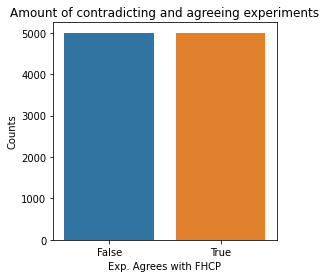

In [561]:
plt.figure(figsize= (4,4))
sns.barplot(y = 'Counts'
            , x ='Exp. Agrees with FHCP'
            , data = plt_df)

plt.title('Amount of contradicting and agreeing experiments')
plt.show()

In [562]:
seeds_flag_df = pd.DataFrame({'seed': seeds
                             , 'experiment_contradicts':contradict_seed_flags})

In [563]:
seeds_flag_df.sample(10)

,seed,experiment_contradicts
7478,7478,False
9977,9977,True
4710,4710,True
6959,6959,True
5972,5972,False
4973,4973,False
6630,6630,True
3976,3976,False
4315,4315,False
7252,7252,False


#### Computing the distributions of 'mean', 'median', 'max' and 'min' of initial tumor size and toxicity values across all experiments

In [564]:
init_patient_data = []
mean_tumor_toxicity_patient_data = [] 
median_tumor_toxicity_patient_data = [] 
min_tumor_toxicity_patient_data = [] 
max_tumor_toxicity_patient_data = [] 

for row in seeds_flag_df.iterrows():
    patient_data = generate_patients(seed = row[1].seed)
    
    mean_tumor_toxicity_patient_data.append(patient_data.mean(axis=0))
    median_tumor_toxicity_patient_data.append(np.median(patient_data,axis=0))
    min_tumor_toxicity_patient_data.append(patient_data.min(axis=0))
    max_tumor_toxicity_patient_data.append(patient_data.max(axis=0))
    
    init_patient_data.append(patient_data)

In [565]:
mean_tumorSize_toxicity_df = pd.DataFrame(np.array(mean_tumor_toxicity_patient_data))
mean_tumorSize_toxicity_df.columns = ['Avg. Tumor Size', 'Avg. Toxicity']

median_tumorSize_toxicity_df = pd.DataFrame(np.array(median_tumor_toxicity_patient_data))
median_tumorSize_toxicity_df.columns = ['Median Tumor Size', 'Median Toxicity']

min_tumorSize_toxicity_df = pd.DataFrame(np.array(min_tumor_toxicity_patient_data))
min_tumorSize_toxicity_df.columns = ['Min Tumor Size', 'Min Toxicity']

max_tumorSize_toxicity_df = pd.DataFrame(np.array(max_tumor_toxicity_patient_data))
max_tumorSize_toxicity_df.columns = ['Max Tumor Size', 'Max Toxicity']


init_patient_summary_data = pd.concat([seeds_flag_df
                                       , mean_tumorSize_toxicity_df
                                       , median_tumorSize_toxicity_df
                                       , min_tumorSize_toxicity_df
                                       , max_tumorSize_toxicity_df]
                                      , axis=1)

In [566]:
init_patient_summary_data.head()

,seed,experiment_contradicts,Avg. Tumor Size,Avg. Toxicity,Median Tumor Size,Median Toxicity,Min Tumor Size,Min Toxicity,Max Tumor Size,Max Toxicity
0,0,False,1.012426,0.970839,1.058881,0.922179,0.023428,0.009391,1.980678,1.997694
1,1,False,0.963620,1.071920,1.002715,1.115343,0.000229,0.025112,1.987826,1.994646
2,2,True,0.979307,0.934901,0.929526,0.908024,0.004965,0.009327,1.989901,1.977724
3,3,False,0.986242,0.968282,1.006651,0.959747,0.001491,0.004251,1.991573,1.997877
4,4,True,1.067221,1.014514,1.046100,1.077856,0.012648,0.012461,1.972449,1.981594


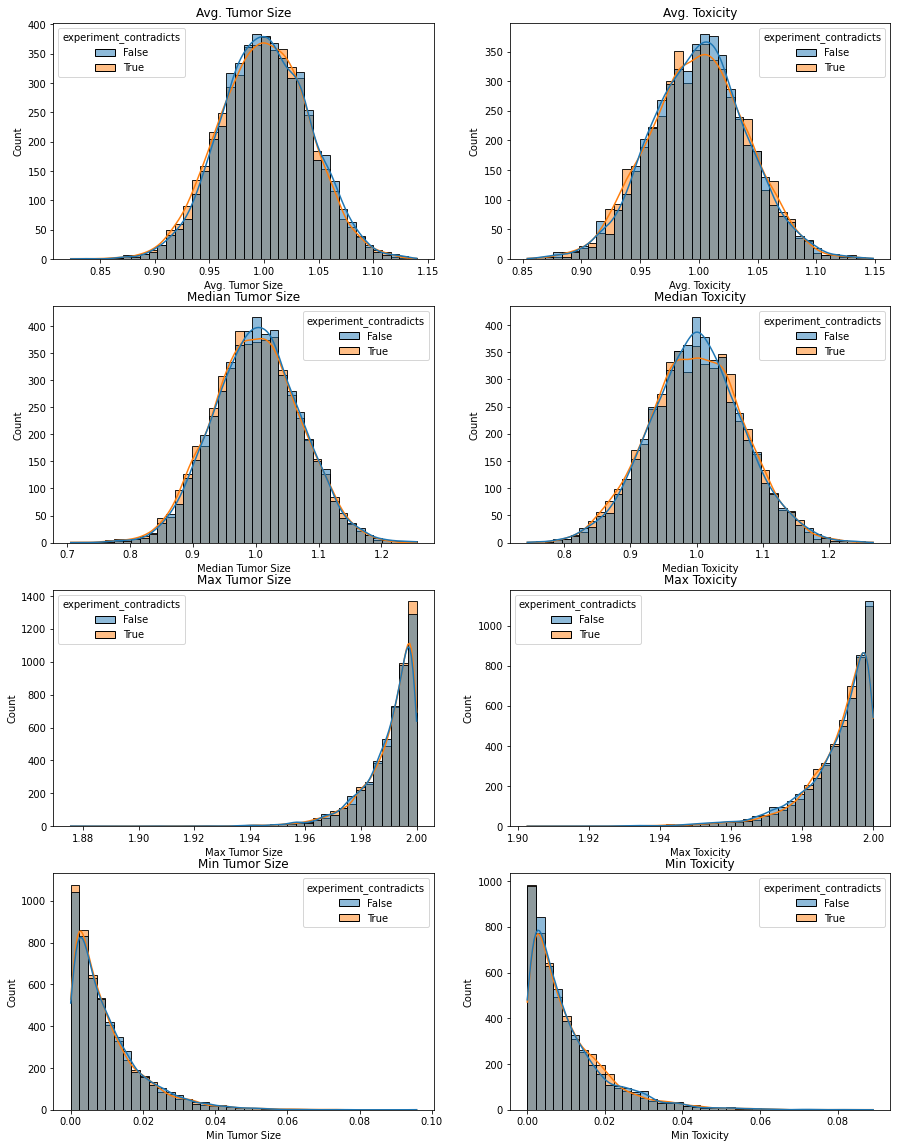

In [567]:
fig, ax = plt.subplots(nrows=4, ncols=2,figsize=(15,20))

sns.histplot(data= init_patient_summary_data, x= 'Avg. Tumor Size', hue = 'experiment_contradicts', kde=True, bins=40, ax = ax[0,0])
sns.histplot(data= init_patient_summary_data, x= 'Avg. Toxicity', hue = 'experiment_contradicts', kde=True, bins=40,   ax = ax[0,1])
ax[0,0].set_title('Avg. Tumor Size')
ax[0,1].set_title('Avg. Toxicity')


sns.histplot(data= init_patient_summary_data, x= 'Median Tumor Size', hue = 'experiment_contradicts', kde=True, bins=40, ax = ax[1,0])
sns.histplot(data= init_patient_summary_data, x= 'Median Toxicity', hue = 'experiment_contradicts', kde=True, bins=40,  ax = ax[1,1])
ax[1,0].set_title('Median Tumor Size')
ax[1,1].set_title('Median Toxicity')


sns.histplot(data= init_patient_summary_data, x= 'Max Tumor Size', hue = 'experiment_contradicts', kde=True, bins=40, ax = ax[2,0])
sns.histplot(data= init_patient_summary_data, x= 'Max Toxicity', hue = 'experiment_contradicts', kde=True, bins=40,  ax = ax[2,1])
ax[2,0].set_title('Max Tumor Size')
ax[2,1].set_title('Max Toxicity')

sns.histplot(data= init_patient_summary_data, x= 'Min Tumor Size', hue = 'experiment_contradicts', kde=True, bins=40, ax = ax[3,0])
sns.histplot(data= init_patient_summary_data, x= 'Min Toxicity', hue = 'experiment_contradicts', kde=True, bins=40,  ax = ax[3,1])
ax[3,0].set_title('Min Tumor Size')
ax[3,1].set_title('Min Toxicity')

plt.show()

#### Sample 'Agreeing' and 'Contradicting' Patients and plot their tumor and toxicity value densities

In [615]:
# Get patient data separately for agreeing and contradicting experiments
all_agreeing_patient_data = []
all_contradicting_patient_data = []

for i, seed_f in enumerate(contradict_seed_flags):
    if seed_f:
        all_contradicting_patient_data.append(init_patient_data[i])
    else:
        all_agreeing_patient_data.append(init_patient_data[i])

all_agreeing_patient_data = np.array(all_agreeing_patient_data )
all_contradicting_patient_data = np.array(all_contradicting_patient_data)

In [653]:
# Randomly select 10 patients
agreeing_selection = np.random.randint(0,len(all_agreeing_patient_data),size=10)
contradicting_selection = np.random.randint(0,len(all_contradicting_patient_data),size=10)

agreeing_patients = all_agreeing_patient_data[agreeing_selection]
contradicting_patients = all_contradicting_patient_data[contradicting_selection]

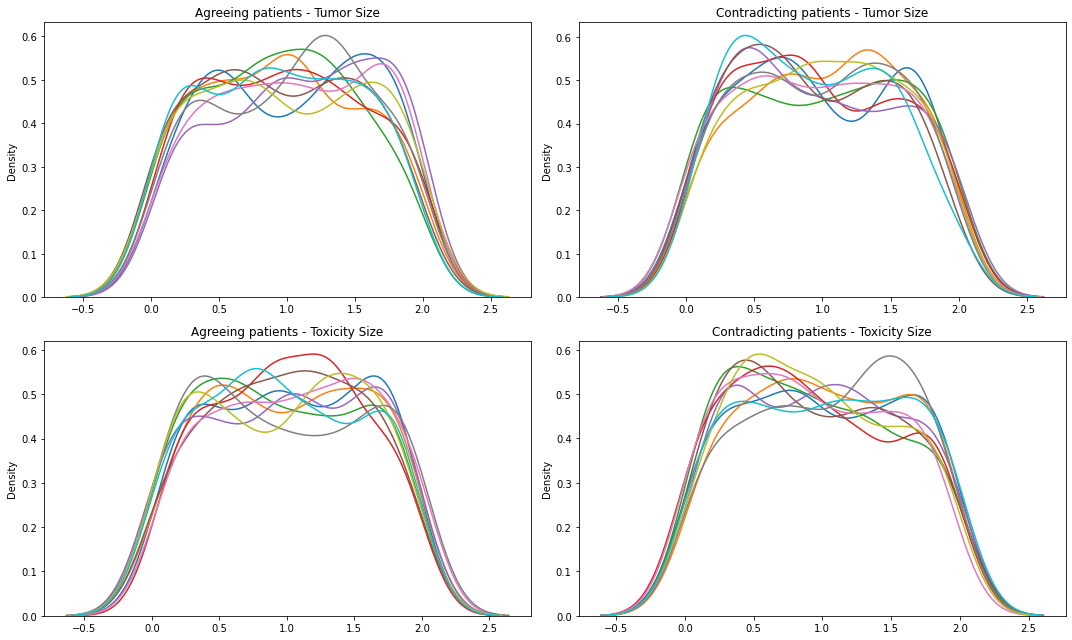

In [671]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(15,9))

for patient in agreeing_patients:
    sns.kdeplot(patient[:,0], ax=ax[0,0])
    
for patient in contradicting_patients:
    sns.kdeplot(patient[:,0], ax=ax[0,1])


for patient in agreeing_patients:
    sns.kdeplot(patient[:,1], ax=ax[1,0])
    
for patient in contradicting_patients:
    sns.kdeplot(patient[:,1], ax=ax[1,1])
    
ax[0,0].set_title('Agreeing patients - Tumor Size')
ax[0,1].set_title('Contradicting patients - Tumor Size')
ax[1,0].set_title('Agreeing patients - Toxicity Size')
ax[1,1].set_title('Contradicting patients - Toxicity Size')

plt.tight_layout()

#### Plot the initial tumor size and toxicity value distributions of an experiment (for a given seed value), and the evaluation results of the corresponding experiment

In [583]:
def check_sample_experiment(contradicting_experiment=True, seed=None):
    
    if seed is not None:
        seed = seed
    else:
        # Test for a observed (contradicting seed)
        seed = seeds_flag_df[seeds_flag_df.experiment_contradicts == contradicting_experiment].seed.sample().values[0]
        
    print(f"-----------------------------------------\
    \nSeed value: {seed} | Contradicting experiment: {contradicting_experiment}\
    \n-----------------------------------------")
    df, flag = run_experiment(seed = seed, show_plot=True)

    patient_data = generate_patients(seed = seed)
    patient_data = pd.DataFrame({'Initial tumor size': patient_data[:,0]
                                 , 'Initial toxicity' : patient_data[:,1]})

    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

    sns.histplot(patient_data
                , x = 'Initial tumor size'
                , bins = 40
                , color= 'red'
                , kde = True
                , ax = ax[0])
    ax[0].set_title('Initial tumor sizes of patients')

    sns.histplot(patient_data
                , x = 'Initial toxicity'
                , bins = 40
                , kde = True
                , ax = ax[1])
    ax[1].set_title('Initial toxicities of patients')

    plt.tight_layout()

-----------------------------------------    
Seed value: 9025 | Contradicting experiment: False    
-----------------------------------------
         Max. Toxicity  Tumor Size
index                             
extreme       5.949854    0.000000
high          3.527046    1.202061
rand          2.660094    2.140605
mid           1.607445    2.814122
low           1.414576    5.324273


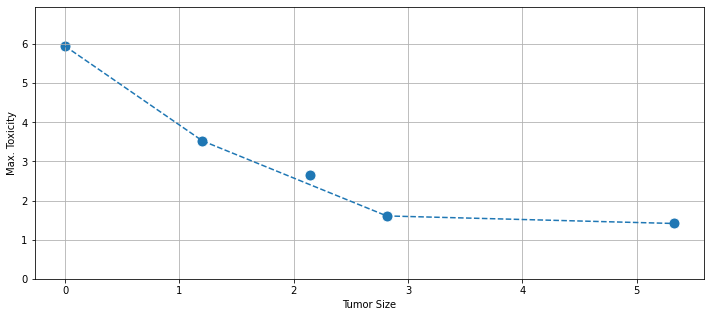

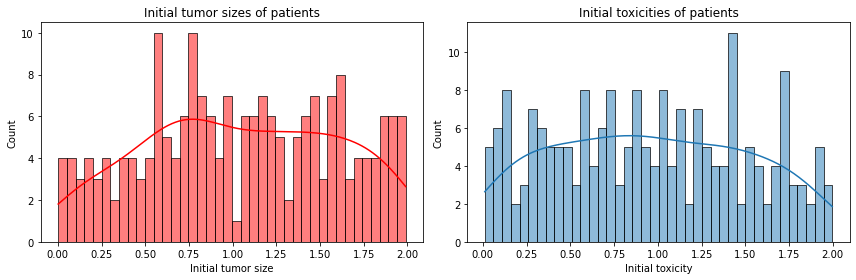

In [586]:
check_sample_experiment(contradicting_experiment=False)

-----------------------------------------    
Seed value: 8402 | Contradicting experiment: True    
-----------------------------------------
         Max. Toxicity  Tumor Size
index                             
extreme       5.279626    0.000000
rand          2.399626    1.037854
high          2.759626    1.055854
mid           0.530491    2.512099
low           0.058294    4.880255


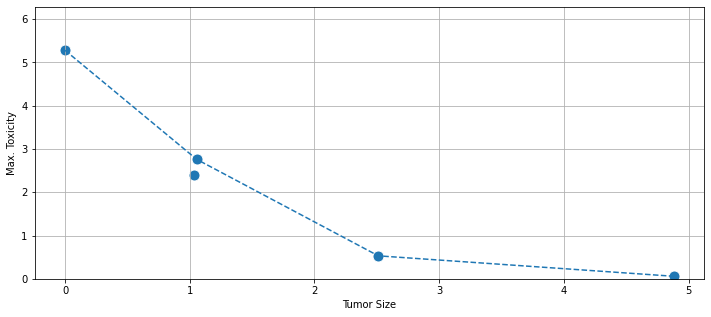

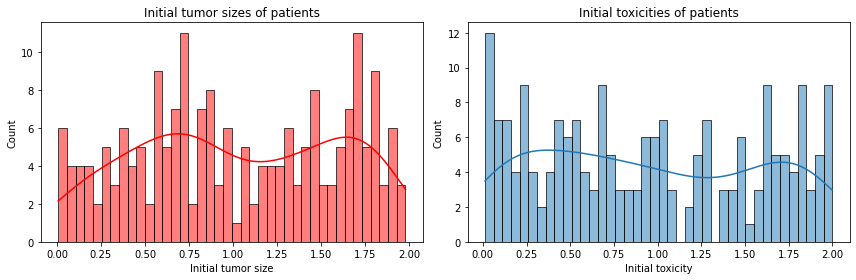

In [591]:
check_sample_experiment(contradicting_experiment=True)